In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

In [22]:
# Establish directory locations

parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir    = os.path.join(parent_dir, 'Output')
pos_data_dir  = os.path.join(parent_dir, 'Plotting_tools/shared_data')

In [23]:
all_positions = pd.read_csv(os.path.join(pos_data_dir, 'rt_positions.csv'))
all_positions['datetime'] = pd.to_datetime(all_positions['date'])

In [24]:
platform_mask = {
        'Ship':  'x',
        'glider': '^',
        'Float':  'o',
        'respire': '>'}

platform_colors = {
        'Discovery':  'black',
        'unit_405': '#b2182b',
        'unit_397':  '#f4a582',
        'unit_398': '#d6604d',
        'unit_345': '#fddbc7',
        'lovuse031c': '#92c5de',
        'lovuse032c': '#4393c3',
        'lovuse026d': '#2166ac',
        'respire': '#b8e186'}

def get_color(platform_id):
    return platform_colors.get(platform_id, 'black')

all_positions['color'] = all_positions['platform_id'].apply(get_color)

In [25]:
autonomy_positions = all_positions[all_positions['platform_type'] != 'Ship']

In [26]:
max_lon = autonomy_positions['lon'].max() + 0.05
min_lon = autonomy_positions['lon'].min() - 0.05
max_lat = autonomy_positions['lat'].max() + 0.05
min_lat = autonomy_positions['lat'].min() - 0.05


In [27]:
positions = all_positions.loc[all_positions.groupby('platform_id')['date'].idxmax()]

In [28]:
import datetime
current_time = datetime.datetime.now()
now = current_time.strftime(format = '%Y-%m-%d %H:%M:%S')

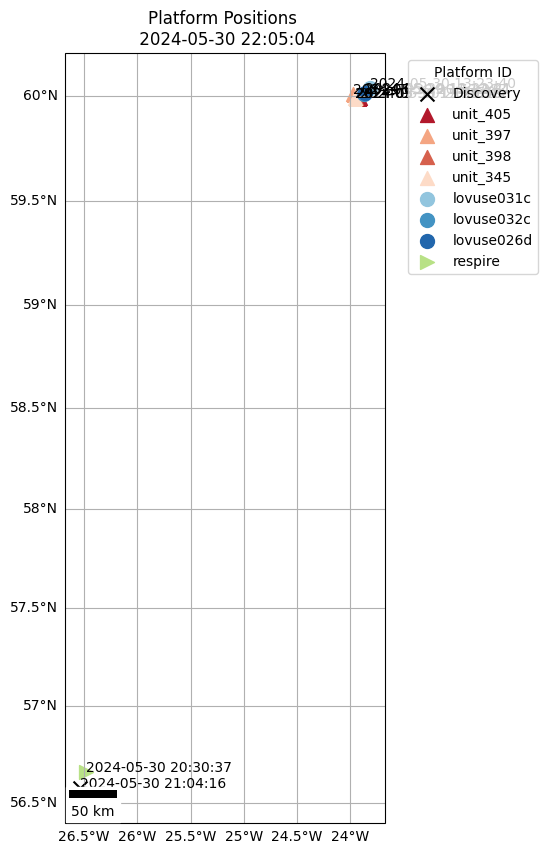

In [29]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

                    # Set the map extent based on your latitude and longitude ranges
#ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


for platform_type, mask in platform_mask.items():
    subset = positions[positions['platform_type'] == platform_type]
    for platform_id, color in platform_colors.items():
        sub_subset = subset[subset['platform_id'] == platform_id]
        if not sub_subset.empty:
            ax.scatter(sub_subset['lon'], sub_subset['lat'], c=color, label=platform_id, marker=mask, s=100, transform=ccrs.PlateCarree())
            for index, row in sub_subset.iterrows():
                ax.annotate(str(row['date']), (row['lon'], row['lat']), transform=ccrs.PlateCarree())

# Add a scale bar
ax.add_artist(ScaleBar(1, location = "lower left"))

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Platform Positions \n {now}')

plt.legend(title='Platform ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the coordinates as needed
plt.show()


plt.close()



In [30]:
positions_from_start = all_positions[all_positions['datetime'] > pd.to_datetime('2024-05-30 00:00:01')]

In [31]:
floats_positions = all_positions[all_positions['platform_type'] == 'Float']

In [32]:
dates_of_gliders = positions_from_start[positions_from_start['platform_type'] == 'glider']['date'].unique()

In [17]:
for i in tqdm(dates_of_gliders):
    temp = all_positions[all_positions['datetime']< pd.to_datetime(i)]
    temp = temp.loc[temp.groupby('platform_id')['datetime'].idxmax()]
    datename = i.replace(" ", "_").replace(":", "").replace("-", "")
    filename = parent_dir + '/Output/Plots/rt_tracking/rt_tracking_' + datename + '.png'


    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

                        # Set the map extent based on your latitude and longitude ranges
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


    for platform_type, mask in platform_mask.items():
        subset = temp[temp['platform_type'] == platform_type]
        for platform_id, color in platform_colors.items():
            sub_subset = subset[subset['platform_id'] == platform_id]
            if not sub_subset.empty:
                ax.scatter(sub_subset['lon'], sub_subset['lat'], c=color, label=platform_id, marker=mask, s=100, transform=ccrs.PlateCarree())
                for index, row in sub_subset.iterrows():
                    ax.annotate(str(row['date']), (row['lon'], row['lat']), transform=ccrs.PlateCarree())

    ax.scatter(-24, 60, label = 'Station 1', marker = 'X', c = 'Black', transform = ccrs.PlateCarree(), s = 200)

    # Add a scale bar
    ax.add_artist(ScaleBar(1, location = "lower left"))

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.top_labels=False   # suppress top labels
    gl.right_labels=False # suppress right labels

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Platform Positions \n {i}')

    plt.legend(title='Platform ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the coordinates as needed

    plt.savefig(filename)
    plt.close()


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]
